In [161]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/demand-forecasting/data_lstm.csv


In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense ,Dropout

In [163]:
df = pd.read_csv("/kaggle/input/demand-forecasting/data_lstm.csv")
df.head()

,city_id,date_int,time_block,hour,iconcode,precipitation,pressurechange,pressuremeansealevel,relativehumidity,temperature,...,visibility,winddirection,windgust,windspeed,demand,month,year,day_of_week,day_of_year,day_of_month
0,7,20240101,24,6,20.0,0.0,0.30,1017.90,93.70,9.70,...,0.13,40.0,0.0,2.50,1638.00,1,2024,0,1,1
1,7,20240101,25,7,20.0,0.0,0.45,1018.18,91.25,9.57,...,0.35,37.5,0.0,3.32,1731.75,1,2024,0,1,1
2,7,20240101,26,7,20.0,0.0,0.60,1018.45,88.80,9.45,...,0.56,35.0,0.0,4.15,1832.87,1,2024,0,1,1
3,7,20240101,27,7,20.0,0.0,0.75,1018.72,86.35,9.32,...,0.78,32.5,0.0,4.97,1932.22,1,2024,0,1,1
4,7,20240101,28,7,20.0,0.0,0.90,1019.00,83.90,9.20,...,1.00,30.0,0.0,5.80,2021.00,1,2024,0,1,1


In [164]:
df['Date'] =pd.to_datetime(df['date_int'],format="%Y%m%d")

In [165]:
max(df['date_int']), min(df['date_int'])

(20250502, 20240101)

In [166]:
train_df = df[(df['date_int'] >= 20240101) & (df['date_int'] <= 20250131)]
test_df = df[(df['date_int'] >= 20250201) & (df['date_int'] <= 20250228)]

In [167]:
model_data = train_df[train_df['city_id']==7]
model_data_test = test_df[test_df['city_id']==7]

In [168]:
model_data=model_data[['date_int','time_block','demand']]
model_data_test=model_data_test[['date_int','time_block','demand']]

In [169]:
# Combine date and block number to datetime (15-min intervals)
model_data['Datetime'] = pd.to_datetime(model_data['date_int'],format="%Y%m%d") + pd.to_timedelta((model_data['time_block'] - 1) * 15, unit='m')


model_data_test['Datetime'] = pd.to_datetime(model_data_test['date_int'],format="%Y%m%d") + pd.to_timedelta((model_data_test['time_block'] - 1) * 15, unit='m')

In [170]:
model_data_test

,date_int,time_block,demand,Datetime
257123,20250201,1,1559.60,2025-02-01 00:00:00
257124,20250201,2,1547.02,2025-02-01 00:15:00
257125,20250201,3,1537.43,2025-02-01 00:30:00
257126,20250201,4,1528.00,2025-02-01 00:45:00
257127,20250201,5,1518.23,2025-02-01 01:00:00
...,...,...,...,...
275358,20250228,92,1453.00,2025-02-28 22:45:00
275359,20250228,93,1429.03,2025-02-28 23:00:00
275360,20250228,94,1405.78,2025-02-28 23:15:00
275361,20250228,95,1384.74,2025-02-28 23:30:00


In [171]:
model_data = model_data[['Datetime', 'demand']]
model_data.set_index('Datetime', inplace=True)

In [172]:
model_data_test = model_data_test[['Datetime', 'demand']]
model_data_test.set_index('Datetime', inplace=True)

In [173]:
model_data

,demand
Datetime,
2024-01-01 05:45:00,1638.00
2024-01-01 06:00:00,1731.75
2024-01-01 06:15:00,1832.87
2024-01-01 06:30:00,1932.22
2024-01-01 06:45:00,2021.00
...,...
2025-01-31 22:45:00,1710.00
2025-01-31 23:00:00,1669.07
2025-01-31 23:15:00,1633.14


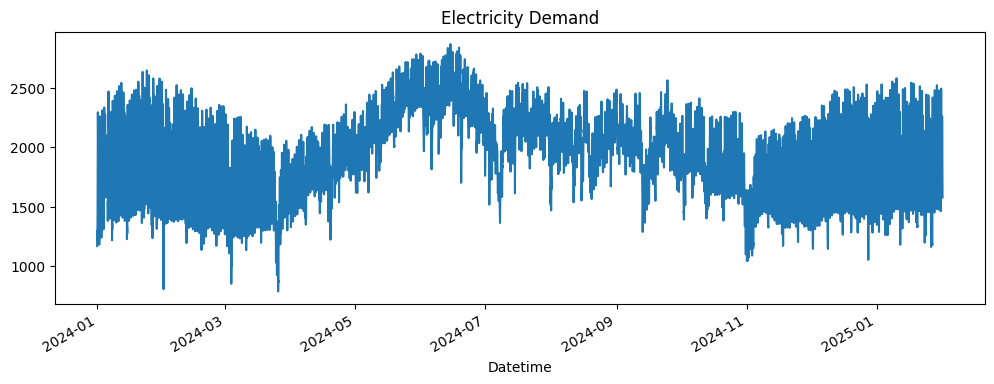

In [174]:
model_data = model_data.sort_index()

# Plot the demand
model_data['demand'].plot(figsize=(12, 4), title='Electricity Demand')
plt.show()

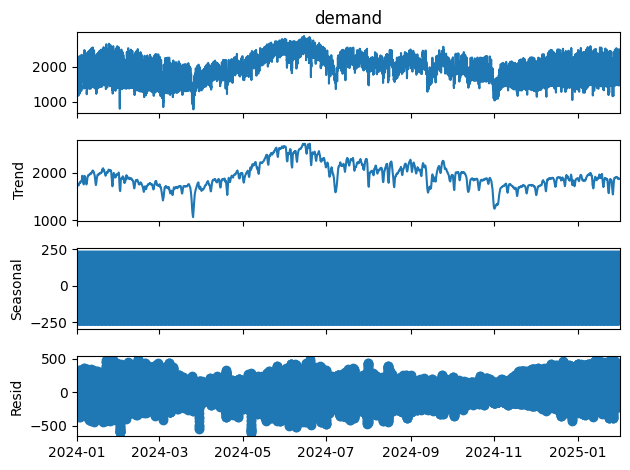

In [175]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(model_data['demand'], model='additive', period=96)  # 96 blocks per day
result.plot()
plt.show()


In [176]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(model_data)

In [177]:
test_scaled = scaler.transform(model_data_test)



In [178]:
# Function to create input-output sequences
def create_sequences(data, window_size=96):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Window size = 1 day = 96 blocks
window_size = 96
X_train, y_train = create_sequences(train_scaled, window_size)

X_test, y_test = create_sequences(test_scaled, window_size)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [179]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization ,LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import Huber
from tensorflow.keras.activations import swish
from tensorflow.keras.optimizers import Adam


model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    LayerNormalization(),
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.0005))),
    LayerNormalization(),
    Dropout(0.2),

    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0005))),
    LayerNormalization(),
    Dropout(0.2),

    Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.0005))),
    Dropout(0.2),

    Dense(64, activation=swish),
    Dense(32, activation=swish),
    Dense(1)
])

model.compile(optimizer='adam', loss=Huber())

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - loss: 0.2450 - val_loss: 0.0192
Epoch 2/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - loss: 0.0134 - val_loss: 0.0036
Epoch 3/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 4/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - loss: 0.0013 - val_loss: 5.4059e-04
Epoch 5/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - loss: 7.0887e-04 - val_loss: 6.1072e-04
Epoch 6/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - loss: 6.1081e-04 - val_loss: 2.7784e-04
Epoch 7/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - loss: 4.6987e-04 - val_loss: 2.8219e-04
Epoch 8/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - loss: 4.1078e-04 - val_loss: 1.9517e-04
Epoch 9/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - loss: 3.8530e-04 - val_loss: 1.8588e-04
Epoch 10/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - loss: 3.6916e-04 - val_loss: 1.2910e-04
Epoch 11/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step -

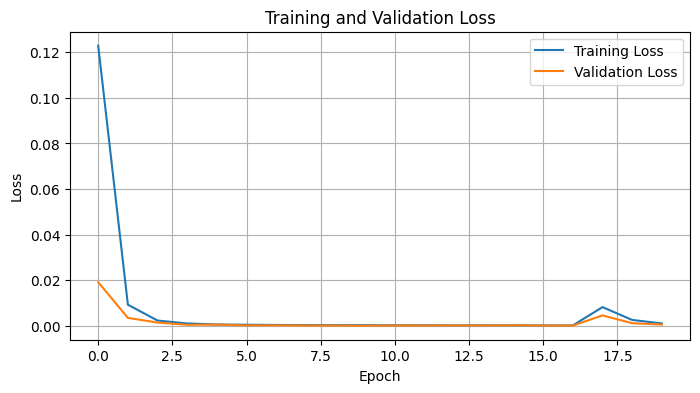

In [200]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [201]:
# Predict
predicted_scaled = model.predict(X_test)

# Inverse transform
predicted = scaler.inverse_transform(predicted_scaled)
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))
len(y_test_true)


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


2592

In [202]:
df_test =pd.concat([pd.DataFrame(y_test_true,columns=['Actual']), pd.DataFrame(predicted,columns=['Predicted'])],axis=1)

<Axes: >

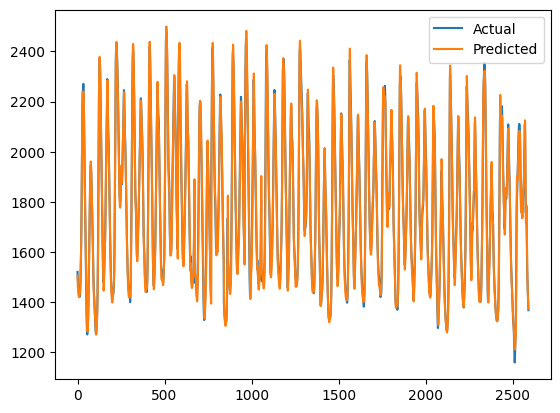

In [203]:
df_test[:].plot()

In [204]:
df_final=pd.concat([model_data_test[96:].reset_index(),pd.DataFrame(predicted,columns=['Predicted'])],axis=1)

In [205]:
def daily_mape(group):
    return np.mean(np.abs((group['demand'] - group['Predicted']) / group['demand'])) * 100

# Compute daily MAPE
daily_mape_values = df_final.groupby('Datetime').apply(daily_mape)

/tmp/ipykernel_35/3619636556.py:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



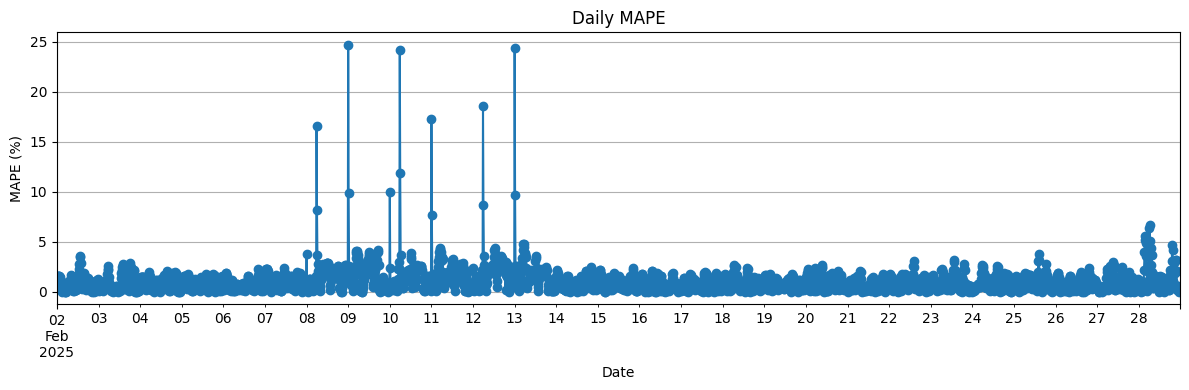

Average MAPE for February: 1.13%


In [206]:

# Plot daily MAPE
plt.figure(figsize=(12, 4))
daily_mape_values.plot(marker='o')
plt.title("Daily MAPE")
plt.ylabel("MAPE (%)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: print average MAPE over the month
print(f"Average MAPE for February: {daily_mape_values.mean():.2f}%")

In [207]:
daily_mape_values=daily_mape_values.reset_index()

In [208]:
daily_mape_values['Date'] = daily_mape_values['Datetime'].dt.date
daily_mape_values['Time'] = daily_mape_values['Datetime'].dt.time

# Reorder columns (optional)
daily_mape_values = daily_mape_values[['Datetime', 'Date', 'Time', 0]]

In [209]:
daily_mape_values[['Date',0]].groupby(['Date']).mean()

,0
Date,
2025-02-02,0.914766
2025-02-03,0.837427
2025-02-04,0.836165
2025-02-05,0.889215
2025-02-06,0.752149
2025-02-07,0.884209
2025-02-08,1.877722
2025-02-09,2.053285
2025-02-10,1.811597


In [210]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import mean_absolute_percentage_error

In [211]:
df_final['Date'] = df_final['Datetime'].dt.date
df_final['Time'] = df_final['Datetime'].dt.time

In [212]:
df_final['date'] = df_final['Date'].astype(str)

# Optional: create 15-minute block numbers in a day (0–95)
df_final['time_block'] = df_final['Datetime'].dt.hour * 4 + df_final['Datetime'].dt.minute // 15

# Filter February data only
feb_df = df_final[df_final['Datetime'].dt.month == 2]

# Get unique sorted February dates
feb_dates = sorted(feb_df['date'].unique())
num_days = len(feb_dates)

In [213]:
titles = []
daily_dfs = []

for date in feb_dates:
    daily_data = feb_df[feb_df['date'] == date]

    # ⬇️ Aggregate by time_block (average)
    daily_avg = daily_data.groupby('time_block')[['demand', 'Predicted']].mean().reset_index()
    daily_dfs.append(daily_avg)

    # Calculate MAPE after aggregation
    mape = mean_absolute_percentage_error(daily_avg['demand'], daily_avg['Predicted']) * 100
    titles.append(f"{date} (MAPE: {mape:.2f}%)")

# Subplot grid size
cols = 4
rows = (num_days + cols - 1) // cols

fig = make_subplots(rows=rows, cols=cols, subplot_titles=titles)

# Add traces for each day's data
for idx, daily_df in enumerate(daily_dfs):
    row = (idx // cols) + 1
    col = (idx % cols) + 1

    fig.add_trace(go.Scatter(
        x=daily_df['time_block'],
        y=daily_df['demand'],
        mode='lines',
        name='demand',
        line=dict(color='blue'),
        showlegend=(idx == 0)
    ), row=row, col=col)

    fig.add_trace(go.Scatter(
        x=daily_df['time_block'],
        y=daily_df['Predicted'],
        mode='lines',
        name='Predicted',
        line=dict(color='red'),
        showlegend=(idx == 0)
    ), row=row, col=col)

# Update layout
fig.update_layout(
    height=300 * rows,
    width=1200,
    title_text="February Daily Predictions (Actual vs Predicted with MAPE)",
    legend=dict(x=1.02, y=1),
    margin=dict(t=80)
)

fig.show()


In [214]:
full_demand_series = model_data['demand'].values.reshape(-1, 1)

# Scale it
demand_scaler = MinMaxScaler()
scaled_demand = demand_scaler.fit_transform(full_demand_series)

In [215]:
window_size = 96
n_forecast_steps = 5 * 96  # 31 days × 96 blocks/day

# Start with last `window_size` points from Feb
input_seq = scaled_demand[-window_size:].reshape(1, window_size, 1)

predictions_scaled = []

for _ in range(n_forecast_steps):
    pred = model.predict(input_seq)[0][0]  # single step prediction
    predictions_scaled.append(pred)

    # Append prediction and move window
    input_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

In [216]:
# Convert list to array
predictions_scaled = np.array(predictions_scaled).reshape(-1, 1)

# Inverse transform
predictions = demand_scaler.inverse_transform(predictions_scaled)

In [217]:
import pandas as pd

# Generate timestamp range for March
start_time = pd.to_datetime('2025-02-01')
datetime_index = pd.date_range(start=start_time, periods=n_forecast_steps, freq='15min')

# Combine into a DataFrame
feb_forecast = pd.DataFrame({
    'Datetime': datetime_index,
    'Predicted_Demand': predictions.ravel()
})

In [218]:
df_lstm=pd.merge(feb_forecast, df_final[['Datetime','demand','Date','time_block']], on='Datetime', how='left').dropna()

In [219]:
titles = []
daily_dfs = []

# Get unique sorted February dates
feb_dates = sorted(df_lstm['Date'].unique())
num_days = len(feb_dates)
for date in feb_dates:
    daily_data = df_lstm[df_lstm['Date'] == date]

    # ⬇️ Aggregate by time_block (average)
    daily_avg = daily_data.groupby('time_block')[['demand', 'Predicted_Demand']].mean().reset_index()
    daily_dfs.append(daily_avg)
    # print(daily_dfs)

    # Calculate MAPE after aggregation
    mape = mean_absolute_percentage_error(daily_avg['demand'], daily_avg['Predicted_Demand']) * 100
    titles.append(f"{date} (MAPE: {mape:.2f}%)")

# Subplot grid size
cols = 4
rows = (num_days + cols - 1) // cols

fig = make_subplots(rows=rows, cols=cols, subplot_titles=titles)

# Add traces for each day's data
for idx, daily_df in enumerate(daily_dfs):
    row = (idx // cols) + 1
    col = (idx % cols) + 1

    fig.add_trace(go.Scatter(
        x=daily_df['time_block'],
        y=daily_df['demand'],
        mode='lines',
        name='demand',
        line=dict(color='blue'),
        showlegend=(idx == 0)
    ), row=row, col=col)

    fig.add_trace(go.Scatter(
        x=daily_df['time_block'],
        y=daily_df['Predicted_Demand'],
        mode='lines',
        name='Predicted',
        line=dict(color='red'),
        showlegend=(idx == 0)
    ), row=row, col=col)

# Update layout
fig.update_layout(
    height=300 * rows,
    width=1200,
    title_text="February Daily Predictions (Actual vs Predicted with MAPE)",
    legend=dict(x=1.02, y=1),
    margin=dict(t=80)
)

fig.show()


In [220]:
model.save("my_model.h5") 